In [184]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

In [185]:
df_2024 = pd.read_parquet(r"C:\Users\Guest_Account\Desktop\Futures Strategies\Futures_2024.parquet", engine='pyarrow')
df_2023 = pd.read_parquet(r"C:\Users\Guest_Account\Desktop\Futures Strategies\Futures_2023.parquet", engine='pyarrow')

In [186]:
df = pd.concat([df_2023, df_2024])
df = df[[col for col in df.columns if 'Close' in col]]
price = df['AUROPHARMA_Close']
prices = price.to_frame(name=' AUROPHARMA Price')
prices.index = pd.to_datetime(prices.index)
prices.index.name = 'Datetime'
prices = prices.resample('D').last()
prices.dropna(inplace=True)

In [191]:
#Plan:
#Start with four contracts, and 1000000 capital. 
#Every Day, calculate the new standard devation of returns up to that point (new formula as in book)
#Every Day, calculate N using formula.
#This is our signal, if our current N != int(New N), then buy or sell accordingly and adjust capital..


class FutureStrategyTwo:
    def __init__(self, price, initial_capital= 1000000, target_risk = 20):
        self.prices = prices
        self.mult = 550 #Found in other doc
        self.cash = initial_capital 
        self.targetrisk = target_risk #%, as found in book.
        self.position = 4
        self.trade_log = []
        self.capital_series = pd.Series(index=prices.index)
        self.capital_series.iloc[1] = initial_capital
        self.position_series = pd.Series(index=prices.index)
        


    def calculate_returns_and_std_dev(self):
        returns = (self.prices.diff() / self.prices.shift(1)) * 100
        sd_returns_s = returns.ewm(span = 32).std()
        sd_returns_l = returns.ewm(span = 700).std()
        sd_returns = 0.3*sd_returns_l + 0.7*sd_returns_s
        sd_returns.index = self.prices.index
        
        return sd_returns*16

        
    def calculate_N(self, timestamp, sd_returns):
        price = self.prices.loc[timestamp]
        num_of_contracts = (self.cash * self.targetrisk) / (price * self.mult * sd_returns.loc[timestamp])
        
        
        return int(num_of_contracts)   

    def buy_contract(self, timestamp, contracts):
        price = self.prices.loc[timestamp]
        self.position += contracts
        self.cash -= contracts * price * self.mult
        self.trade_log.append((timestamp, 'BUY', contracts, price))
        self.capital_series[timestamp] = self.capital_series.shift(1).loc[timestamp] + (price - self.prices.shift(1).loc[timestamp])*self.position*self.mult
        self.position_series[timestamp] = self.position

    def sell_contract(self, timestamp, contracts):
        price = self.prices.loc[timestamp]
        self.position -= contracts
        self.cash += contracts * price * self.mult
        self.trade_log.append((timestamp, 'SELL', contracts, price))
        self.capital_series[timestamp] = self.capital_series.shift(1).loc[timestamp] + (price - self.prices.shift(1).loc[timestamp])*self.position*self.mult
        self.position_series[timestamp] = self.position

    def no_trade(self, timestamp, contracts):
        price = self.prices.loc[timestamp]
        self.position += contracts
        self.cash -= contracts * price * self.mult
        self.trade_log.append((timestamp, 'HOLD POSITION', price))
        self.capital_series[timestamp] = self.capital_series.shift(1).loc[timestamp] + (price - self.prices.shift(1).loc[timestamp])*self.position*self.mult
        self.position_series[timestamp] = self.position
    
    def trade(self, timestamp, sd_returns):
    
        num_of_contracts =  self.calculate_N(timestamp, sd_returns)
        contracts_to_trade = num_of_contracts - self.position

        if contracts_to_trade > 0:
            self.buy_contract(timestamp, contracts_to_trade)

        elif contracts_to_trade < 0:
            self.sell_contract(timestamp, -(contracts_to_trade))
        
        elif contracts_to_trade == 0:
            self.no_trade(timestamp, -(contracts_to_trade)) 

        

    

    def get_capital_progression(self):
        return self.capital_series

    def get_trade_log(self):
        return self.trade_log
    
    def get_position_series(self):
        return self.position_series
    
strategy = FutureStrategyTwo(prices)


sd_returns = strategy.calculate_returns_and_std_dev()

for timestamp in prices.index[2:]:  
    strategy.trade(timestamp, sd_returns)

cap_progression = strategy.get_capital_progression()[1:]
print("Capital Progression Over Time:")
print(cap_progression)

trade_log = strategy.get_trade_log()
print("Trade Log:")
print(trade_log)

position_series = strategy.get_position_series()



C:\Users\Guest_Account\AppData\Local\Temp\ipykernel_3500\3141216369.py:37: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  return int(num_of_contracts)
C:\Users\Guest_Account\AppData\Local\Temp\ipykernel_3500\3141216369.py:52: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  self.capital_series[timestamp] = self.capital_series.shift(1).loc[timestamp] + (price - self.prices.shift(1).loc[timestamp])*self.position*self.mult
C:\Users\Guest_Account\AppData\Local\Temp\ipykernel_3500\3141216369.py:44: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  self.capital_series[timestamp] = self.capital_series.shift(1).loc[timestamp] + (price - self.prices.shift(1).loc[timestamp])*self.position*self.mult
C:\Users\Guest_Ac

Capital Progression Over Time:
Datetime
2023-01-03    1000000.0
2023-01-04     996370.0
2023-01-05    1006407.5
2023-01-06    1002530.0
2023-01-09    1004262.5
                ...    
2024-06-26    1745222.5
2024-06-27    1749677.5
2024-06-28    1758340.0
2024-07-01    1762960.0
2024-07-02    1762080.0
Length: 368, dtype: float64
Trade Log:
[(Timestamp('2023-01-04 00:00:00'), 'SELL', 1, AUROPHARMA Price    442.6
Name: 2023-01-04 00:00:00, dtype: float64), (Timestamp('2023-01-05 00:00:00'), 'BUY', 2, AUROPHARMA Price    446.25
Name: 2023-01-05 00:00:00, dtype: float64), (Timestamp('2023-01-06 00:00:00'), 'SELL', 2, AUROPHARMA Price    443.9
Name: 2023-01-06 00:00:00, dtype: float64), (Timestamp('2023-01-09 00:00:00'), 'BUY', 4, AUROPHARMA Price    444.35
Name: 2023-01-09 00:00:00, dtype: float64), (Timestamp('2023-01-10 00:00:00'), 'SELL', 6, AUROPHARMA Price    452.7
Name: 2023-01-10 00:00:00, dtype: float64), (Timestamp('2023-01-11 00:00:00'), 'BUY', 7, AUROPHARMA Price    449.7
Name:

In [192]:
def trade_analysis(returns):
    
    plt.figure(figsize=(12, 6))
    plt.plot(returns, label='Cumulative PnL', color='blue')
    plt.title('Cumulative PnL', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('PnL', fontsize=14)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

    total_return = (returns.iloc[-1] / returns.iloc[0]) 
    number_of_years = ((returns.index[-1] - returns.index[0]).days) / 365
    average_annual_return = ((total_return) ** (1 / number_of_years) - 1)*100
    print(f"The CAGR is: {average_annual_return}%")
    
    mean_returns = returns.pct_change().mean()*252*100
    print(f"The Average Annual Return is: {mean_returns}%")
    
    std_returns = returns.pct_change().std()*(252**0.5) * 100
    print(f"The Average Annual Percentage Risk is: {std_returns}%")
    
    sharpe = mean_returns / std_returns
    print(f"The Sharpe Ratio is: {sharpe}")


    plt.show()


In [193]:
def position_analysis(position_series):
    plt.figure(figsize=(12, 6))
    plt.plot(position_series, label='Position Size', color='blue')
    plt.title('Position Size over Time', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Position', fontsize=14)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    

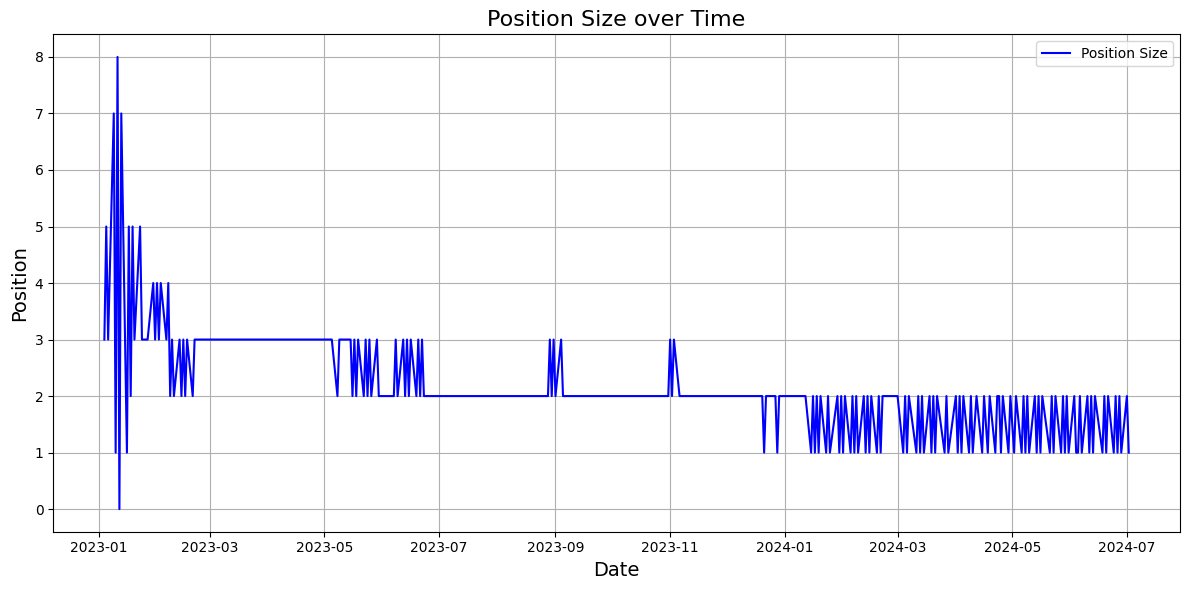

In [194]:
position_analysis(position_series)

The CAGR is: 46.03860561543933%
The Average Annual Return is: 40.61517843385007%
The Average Annual Percentage Risk is: 18.4252017449463%
The Sharpe Ratio is: 2.2043274747311834


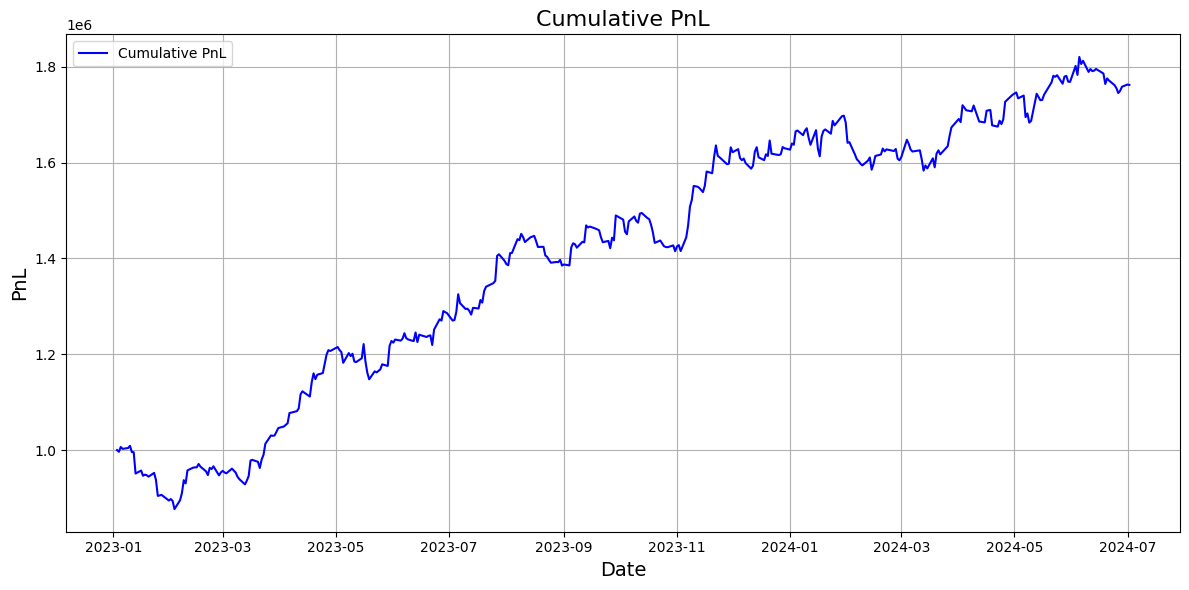

In [189]:
trade_analysis(cap_progression)